In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
!pip install git+https://github.com/fastai/fastai@2e1ccb58121dc648751e2109fc0fbf6925aa8887
    
!apt update && apt install -y libsm6 libxext6

  Cloning https://github.com/fastai/fastai (to revision 2e1ccb58121dc648751e2109fc0fbf6925aa8887) to /tmp/pip-req-build-rwbyexx4
    100% |████████████████████████████████| 496.4MB 73kB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-zg2znaei/wheels/25/e9/9b/223e47f59c39f0bd393733db0f7efe8ec6f078d29c32198f9f
Successfully built fastai
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2
  Found existing installation: fastai 1.0.48
    Uninstalling fastai-1.0.48:
      Successfully uninstalled fastai-1.0.48
Ign:1 http://deb.debian.org/debian stretch InRelease
Get:2 http://security.debian.org/debian-security stretch/updates InRelease [94.3 kB]
Get:3 http://deb.debian.org/debian stretch-updates InRelease [91.0 kB]
Err:2 http://security.debian.org/debian-security stretch/updates InRelease
  Couldn't create temporary file /tmp/apt.conf.7sKAhG for passing config to apt-key
Err:3 http://deb.debian.org/debian 

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
from xgboost import XGBRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

In [4]:
# Path of the file to read. We changed the directory structure to simplify submitting to a competition
PATH = '../input/train.csv'

df_raw = pd.read_csv(PATH,low_memory=False)


In [5]:
df_raw.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [7]:
df_raw.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

**MODEL WITHOUT TUNING**

In [8]:
train_cats(df_raw)

In [9]:
df, y, nas = proc_df(df_raw,'SalePrice')

In [10]:
#if we would like to reorder columns
#code:
#df_raw.BsmtQual.cat.set_categories(['Fa','Ex','Gd','TA'],oredered= True,inplace=True)

In [11]:
#percentages of missing values
#df_raw.isnull().sum().sort_index()/len(df_raw)

In [12]:
#RANDOM FOREST MODEL on whole train set (w/o validation)
#model_RF = RandomForestRegressor(n_jobs = -1)
#model_RF.fit(df, y)
#model_RF.score(df,y)

#kaggle score error: ~17.7k

In [13]:
#XGB MODEL on whole train set (w/o validation)
#model_xgb = XGBRegressor(n_jobs=-1)
#model_xgb.fit(df,y)
#model_xgb.score(df,y)

#kaggle score error: ~15.3k

**MODEL WITH PARAMETER TUNING**

In [14]:
#MAKING OF VALIDATION TEST SET

#function for spliting values
def split_vals(a,n): 
    return a[:n], a[n:]

#400 examples in validation set
n_valid = 400
n_training = len(df_raw)-n_valid

#spliting whole training set

raw_train, raw_valid = split_vals(df_raw, n_training)


In [15]:
#imputing and making new columns for categorical data
train_cats(raw_train)

X_train, y_train, nas = proc_df(raw_train,'SalePrice')

#aplying on validation set and alignin it with train set
apply_cats(raw_valid,raw_train)
X_valid, y_valid, _ = proc_df(raw_valid,'SalePrice', na_dict = nas)

/opt/conda/lib/python3.6/site-packages/fastai/structured.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [16]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape


((1060, 83), (1060,), (400, 83), (400,))

Text(0.5,1,'SalePrice')

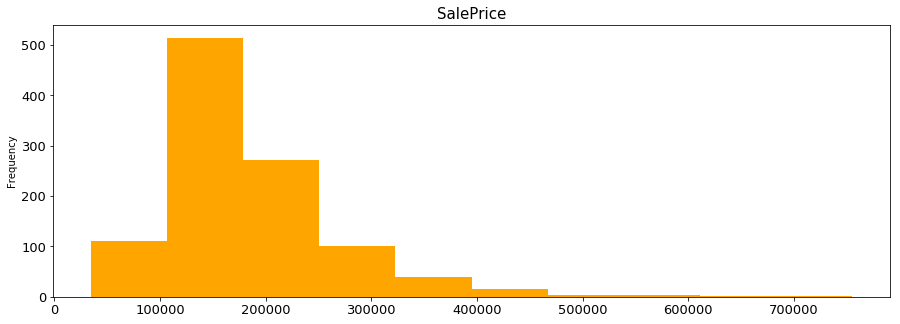

In [17]:
#PLOTING TARGET VARIABLE

plot = raw_train.SalePrice.plot(kind="hist", figsize = (15,5), bins = 10, color="orange", fontsize = 13)
plot.set_title("SalePrice", fontsize = 15)

#Target variable is skewed, has some outliers. But this souldn't hurt RF nor XGB model

#Note: This distribution looks like it could be modeled with some beta or gamma distributions...

**FINDING BEST RANDOM FOREST MODEL**

In [18]:
#DIGRESSION

#set_rf_samples(20000)

#use this comand if:
#e.g we have millions of training examples, but rather than throwing away some data,
#we can limit it to a different random subset per tree.
#this way, given enough trees, our model can still see all the data

#Notes:
# 1) sckit doesn't support this, it's fastai function
# 2) to call it off: -> reset_rf_samples()

In [19]:
#this model is very overfitting
model_RF = RandomForestRegressor(n_jobs = -1,n_estimators=100,oob_score=True)
model_RF.fit(X_train, y_train)
print(model_RF.score(X_train,y_train))
print(model_RF.score(X_valid,y_valid))

0.9793174335938089
0.8301384697165662


**Trying with tuning min_samples_leaf parameter**

In [20]:
model_RF = RandomForestRegressor(n_jobs = -1,n_estimators=100,oob_score=True,min_samples_leaf=1)
model_RF.fit(X_train, y_train)
print(model_RF.score(X_train,y_train))
print(model_RF.score(X_valid,y_valid))

#deafault:1 turns out to be fine

0.9807460603208622
0.8350934642060658


**Trying max_features**

In [21]:
model_RF = RandomForestRegressor(n_jobs = -1,oob_score=True,max_features=0.5)
model_RF.fit(X_train, y_train)
print(model_RF.score(X_train,y_train))
print(model_RF.score(X_valid,y_valid))
#it helps a bit

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.9749134162296236
0.8459567732620903


**intrepeting the model**

In [22]:
fi = rf_feat_importance(model_RF, X_train )

fi[:10]


,cols,imp
17,OverallQual,0.383500
61,GarageCars,0.200569
46,GrLivArea,0.116091
43,1stFlrSF,0.036464
44,2ndFlrSF,0.033414
38,TotalBsmtSF,0.028575
4,LotArea,0.019684
59,GarageYrBlt,0.019045
34,BsmtFinSF1,0.016690
19,YearBuilt,0.009956


In [23]:
#so OverallQual is by far the most important, and so on...

**THE FINDING BEST XGB MODEL**

In [24]:
#XGB is significantly less overfitting than RandomForest model
model_xgb = XGBRegressor(n_jobs = -1,n_estimators=500,random_state=5,max_depth=3,reg_lambda=1)
model_xgb.fit(X_train, y_train)
print(model_xgb.score(X_train,y_train))
print(model_xgb.score(X_valid,y_valid))

0.9934121290736597
0.8906760462321587


In [25]:
predt = model_xgb.predict(X_train)
predv = model_xgb.predict(X_valid)

print(mean_absolute_error(y_train,predt))
print(mean_absolute_error(y_valid,predv))


4722.604705925707
15740.45638671875


**FINDING THE BEST REG_LAMBDA VALUE**

In [26]:
lambdas = np.array([0.01 * ( 2 ** i) for i in range(15)])

lambdas

array([  0.01,   0.02,   0.04,   0.08,   0.16,   0.32,   0.64,   1.28,   2.56,   5.12,  10.24,  20.48,
        40.96,  81.92, 163.84])

In [27]:
scores_train = np.zeros(15)
scores_valid = np.zeros(15)


for i in range(15):
    model_xgb = XGBRegressor(n_jobs = -1,n_estimators=500,random_state=5,max_depth=3,reg_lambda=lambdas[i])
    model_xgb.fit(X_train, y_train)
    scores_train[i] = model_xgb.score(X_train,y_train)
    scores_valid[i] = model_xgb.score(X_valid,y_valid)
    
print(scores_train)
print(scores_valid)

# reg_lambda = 0.64 is fine 

[0.99546 0.99561 0.9951  0.99509 0.99542 0.99476 0.99433 0.99341 0.99236 0.99131 0.98861 0.9863  0.98126
 0.97452 0.96485]
[0.87054 0.87681 0.88901 0.87644 0.884   0.89196 0.8783  0.89131 0.89578 0.89538 0.89031 0.88659 0.88335
 0.87243 0.85947]


In [28]:
model_xgb = XGBRegressor(n_jobs = -1,n_estimators=450,random_state=5,max_depth=3,reg_lambda=0.45)
model_xgb.fit(X_train, y_train)
print(model_xgb.score(X_train,y_train))
print(model_xgb.score(X_valid,y_valid))

0.9936389419411166
0.8849730312602173


In [29]:
predt = model_xgb.predict(X_train)
predv = model_xgb.predict(X_valid)

#competition measure score
print(mean_absolute_error(y_train,predt))
print(mean_absolute_error(y_valid,predv))


4824.392832399764
16217.2166796875


In [30]:
#BEST MODEL KAGGLE SCORED MODEL (turns out lambda = 0.45 is better than 0.64)
model_xgb = XGBRegressor(n_jobs = -1,n_estimators=10000,random_state=5,max_depth=3,reg_lambda=0.45)
model_xgb.fit(df,y)

#score 14.6k $

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10000, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=5, reg_alpha=0,
       reg_lambda=0.45, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

# Make Predictions

In [31]:
# path to file you will use for predictions
test_data_path = '../input/test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path,low_memory=False)

apply_cats(test_data,df_raw)

test_processed_df, _, _ = proc_df(test_data, na_dict = nas)


In [32]:
test_preds = model_xgb.predict(test_processed_df)

In [33]:
output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)